#### What is Parallelization in LangGraph?
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don’t depend on each other’s outputs, you can run them in parallel. This is achieved by:
- Defining multiple nodes that can operate independently.

- Connecting them to a common starting point (e.g., START or another node).

- Merging their outputs into a downstream node if needed.

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (e.g., Python’s asyncio or a multi-threaded executor).

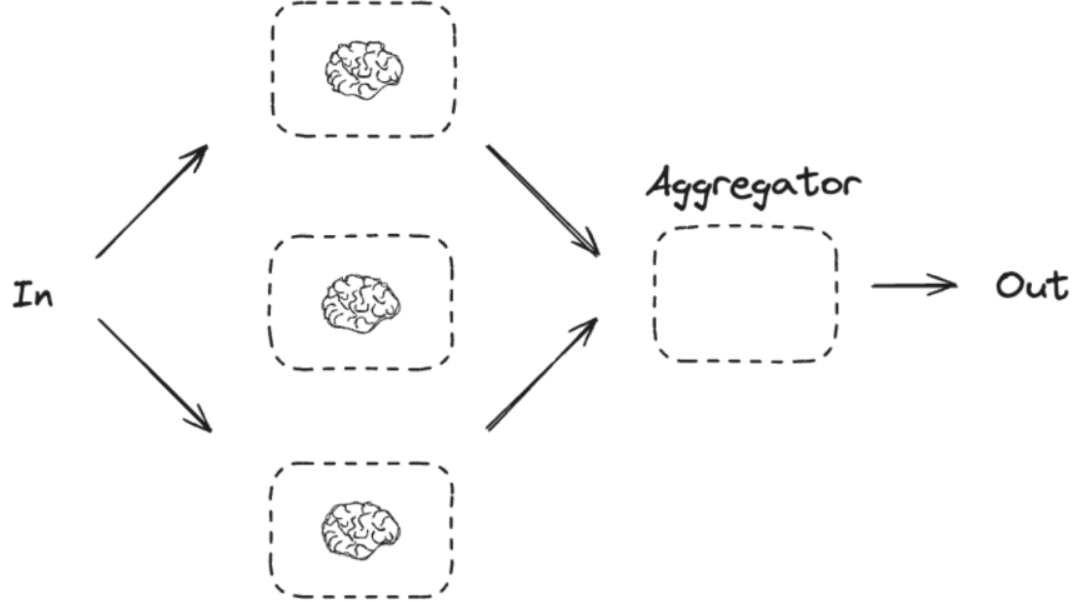

#### Key Benefits
- Speed: Reduces total execution time by running tasks concurrently.

- Scalability: Handles larger workflows efficiently.

- Modularity: Keeps the graph structure clean and reusable.

#### Key Takeaways
- When to Parallelize: Use it for independent tasks (e.g., generating multiple outputs, checking separate inputs).

- Merging: Downstream nodes can aggregate parallel results.

- LangGraph Support: The framework naturally supports this by waiting for all required inputs before proceeding.

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen-qwq-32b")
result=llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user said "Hello". I should respond in a friendly way. Maybe ask how I can assist them today. Keep it simple and open-ended so they feel comfortable to ask anything. Let me make sure there\'s no typo and the tone is welcoming.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 11, 'total_tokens': 78, 'completion_time': 0.168349863, 'prompt_time': 0.004050806, 'queue_time': 14.801710565999999, 'total_time': 0.172400669}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_1e88ca32eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-4bb237e0-22e2-415f-b315-a8c37215fe90-0', usage_metadata={'input_tokens': 11, 'output_tokens': 67, 'total_tokens': 78})

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph State
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str

In [8]:
# Nodes
def generate_characters(state: State):
    """Generate character descriptions"""
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {"characters": msg.content}

def generate_setting(state: State):
    """Generate a story setting"""
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"settings": msg.content}

def generate_premise(state: State):
    """Generate a story premise"""
    msg = llm.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {"premises": msg.content}

def combine_elements(state: State):
    """Combine characters, setting, and premise into an intro"""
    msg = llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state['characters']}\n"
        f"Setting: {state['settings']}\n"
        f"Premise: {state['premises']}"
    )
    return {"story_intro": msg.content}

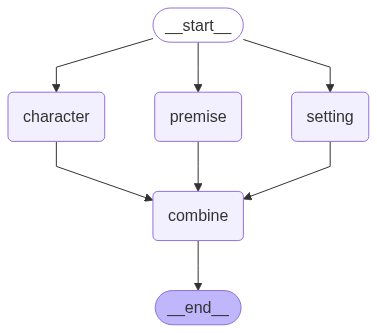

In [9]:
# Build the graph
graph = StateGraph(State)
graph.add_node("character", generate_characters)
graph.add_node("setting", generate_setting)
graph.add_node("premise", generate_premise)
graph.add_node("combine", combine_elements)

# Define edges (parallel execution from START)
graph.add_edge(START, "character")
graph.add_edge(START, "setting")
graph.add_edge(START, "premise")
graph.add_edge("character", "combine")
graph.add_edge("setting", "combine")
graph.add_edge("premise", "combine")
graph.add_edge("combine", END)

# Compile and run
compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [11]:
state = {"topic": "time travel"}
result = compiled_graph.invoke(state)

In [12]:
print(result["story_intro"])


<think>
Okay, the user wants me to create a short story introduction using specific characters, a setting, and a premise. Let's break down the elements they provided. The characters are Dr. Lizzy Voss and Mr. Alden Thorne. The setting is the Eternal Observatory in Chronos Hollow, and the premise is a time travel story where Lizzy's attempt to save her sister causes a paradox.

First, I need to integrate all these elements into a compelling opening. The introduction should hook the reader with vivid descriptions of the setting and hint at the central conflict. Since the user mentioned the observatory's details in the setting, I should highlight the eerie atmosphere there. 

Lizzy's motivation is her daughter's death, so I need to show her desperation. Maybe start with her in the observatory, preparing to use the machine. Alden's skepticism can create tension. The paradox premise means there should be a hint that their actions might backfire.

I'll start with a vivid scene of them activ